<a href="https://colab.research.google.com/github/Shahroz-Harral/demand-forecasting/blob/main/forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Data Preparation

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# Load dataset from GitHub
url = 'https://raw.githubusercontent.com/Shahroz-Harral/demand-forecasting/main/Dataset/train_0irEZ2H.csv'
data = pd.read_csv(url)



In [3]:
# Handle missing values
data = data.fillna(method='ffill')

In [4]:
# Convert week column to datetime
data['week'] = pd.to_datetime(data['week'], format='%y/%m/%d')

In [5]:
# Extract relevant date features
data['year'] = data['week'].dt.year
data['month'] = data['week'].dt.month
data['day'] = data['week'].dt.day
data['week_number'] = data['week'].dt.isocalendar().week

In [6]:
# Define features and target
features = ['year', 'month', 'day', 'week_number', 'store_id', 'sku_id', 'total_price', 'base_price', 'is_featured_sku', 'is_display_sku']
target = 'units_sold'


In [7]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data[features], data[target], test_size=0.2, random_state=42)

# Step 2: Feature Engineering

Feature engineering is crucial for improving model performance. We'll add more features based on domain knowledge and interactions.

In [8]:
# Feature engineering: creating interaction terms
X_train['price_diff'] = X_train['total_price'] - X_train['base_price']
X_test['price_diff'] = X_test['total_price'] - X_test['base_price']

# Additional feature transformations
X_train['total_base_ratio'] = X_train['total_price'] / X_train['base_price']
X_test['total_base_ratio'] = X_test['total_price'] / X_test['base_price']

# Step 3: Model Selection and Training
We will use several models and select the best one based on performance metrics.

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [10]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

In [11]:
# Train and evaluate models
model_performance = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    model_performance[model_name] = mean_squared_error(y_test, y_pred)


In [12]:
# Print model performance
for model_name, mse in model_performance.items():
    print(f"{model_name}: MSE = {mse:.4f}")

Linear Regression: MSE = 2319.4835
Random Forest: MSE = 720.1785
XGBoost: MSE = 590.8568



# Step 4: Model Evaluation and Hyperparameter Tuning



We'll perform hyperparameter tuning on the best model using GridSearchCV.

In [13]:
from sklearn.model_selection import GridSearchCV

In [14]:
# Example with Random Forest
# Reduced parameter grid for GridSearchCV
# Parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=2,  # Reduced number of cross-validation folds
    scoring='neg_mean_squared_error',
    n_jobs=-1  # Use all available cores
)

# Fit the model
grid_search.fit(X_train, y_train)

# Best model and parameters
best_model = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'max_depth': 30, 'min_samples_split': 5, 'n_estimators': 300}


**Step 5: Forecasting and Performance Improvement**

Finally, we use the best model for forecasting and evaluate its performance.

In [16]:
# Predict and evaluate the best model
y_pred_best = best_model.predict(X_test)
best_mse = mean_squared_error(y_test, y_pred_best)
print(f"Best Model MSE: {best_mse:.4f}")

# Forecast future demand (assuming future data structure is similar)
future_weeks = pd.date_range(start=data['week'].max(), periods=30, freq='W')
future_data = pd.DataFrame({
    'week': future_weeks,
    'year': future_weeks.year,
    'month': future_weeks.month,
    'day': future_weeks.day,
    'week_number': future_weeks.isocalendar().week,
    'store_id': [8091]*30,  # Assuming a single store for simplicity
    'sku_id': [216418]*30,  # Assuming a single SKU for simplicity
    'total_price': [100]*30,  # Placeholder values
    'base_price': [90]*30,  # Placeholder values
    'is_featured_sku': [0]*30,
    'is_display_sku': [0]*30
})

# Add engineered features
future_data['price_diff'] = future_data['total_price'] - future_data['base_price']
future_data['total_base_ratio'] = future_data['total_price'] / future_data['base_price']

# Ensure the order of columns matches the order used during training
future_data = future_data[features + ['price_diff', 'total_base_ratio']]

# Forecast
future_predictions = best_model.predict(future_data)

# Output the forecasted demand
forecast = pd.DataFrame({'week': future_weeks, 'predicted_units_sold': future_predictions})
print(forecast)


Best Model MSE: 706.1777
         week  predicted_units_sold
0  2031-10-12             27.022715
1  2031-10-19             27.605984
2  2031-10-26             27.605984
3  2031-11-02             39.239974
4  2031-11-09             39.239974
5  2031-11-16             41.885299
6  2031-11-23             41.885299
7  2031-11-30             43.343379
8  2031-12-07             44.039098
9  2031-12-14             87.386203
10 2031-12-21             87.386203
11 2031-12-28             87.386203
12 2032-01-04             27.261257
13 2032-01-11             27.261257
14 2032-01-18             34.409877
15 2032-01-25             34.409877
16 2032-02-01             27.407765
17 2032-02-08             27.407765
18 2032-02-15             33.169829
19 2032-02-22             33.169829
20 2032-02-29             33.016218
21 2032-03-07             26.445261
22 2032-03-14             32.757107
23 2032-03-21             32.800440
24 2032-03-28             32.800440
25 2032-04-04             26.635955
26 

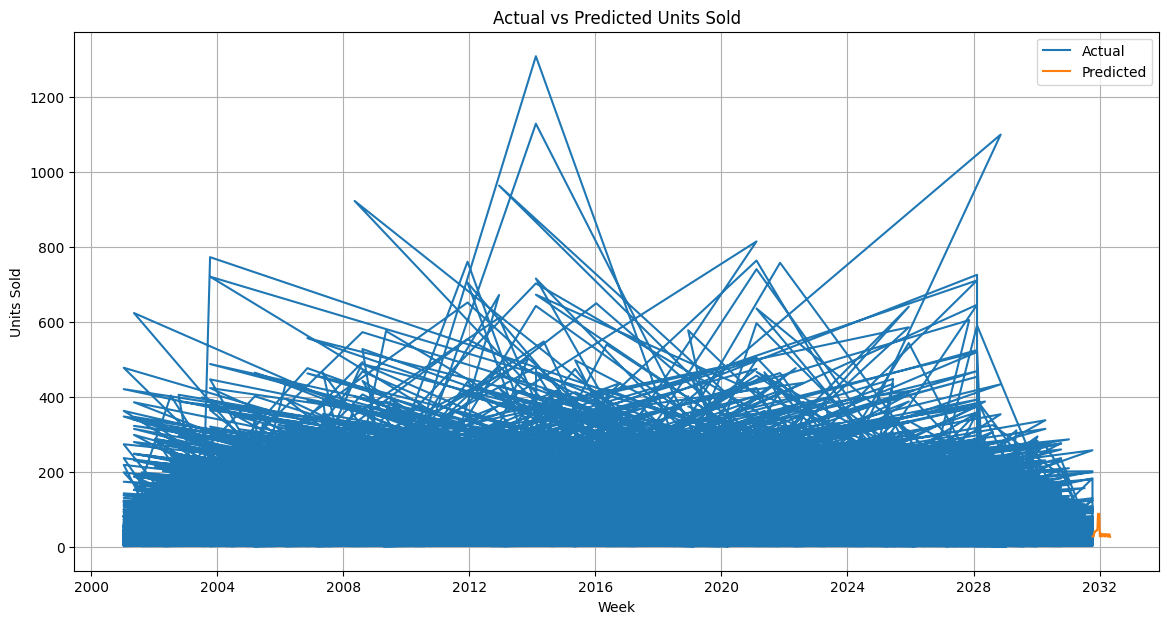

In [23]:
import matplotlib.pyplot as plt

# Re-merge the 'week' column with X_test
X_test_with_week = X_test.copy()
X_test_with_week['week'] = data.loc[X_test.index, 'week']
X_test_with_week['units_sold'] = y_test
X_test_with_week['type'] = 'Actual'

# Ensure future_data includes all necessary columns
future_data['units_sold'] = future_predictions
future_data['type'] = 'Predicted'
future_data['week'] = future_weeks

# Combine actual and predicted data for visualization
combined_data = pd.concat([X_test_with_week[['week', 'units_sold', 'type']], future_data[['week', 'units_sold', 'type']]])

# Plot the results
plt.figure(figsize=(14, 7))
for label, df in combined_data.groupby('type'):
    plt.plot(df['week'], df['units_sold'], label=label)

plt.xlabel('Week')
plt.ylabel('Units Sold')
plt.title('Actual vs Predicted Units Sold')
plt.legend()
plt.grid(True)
plt.show()


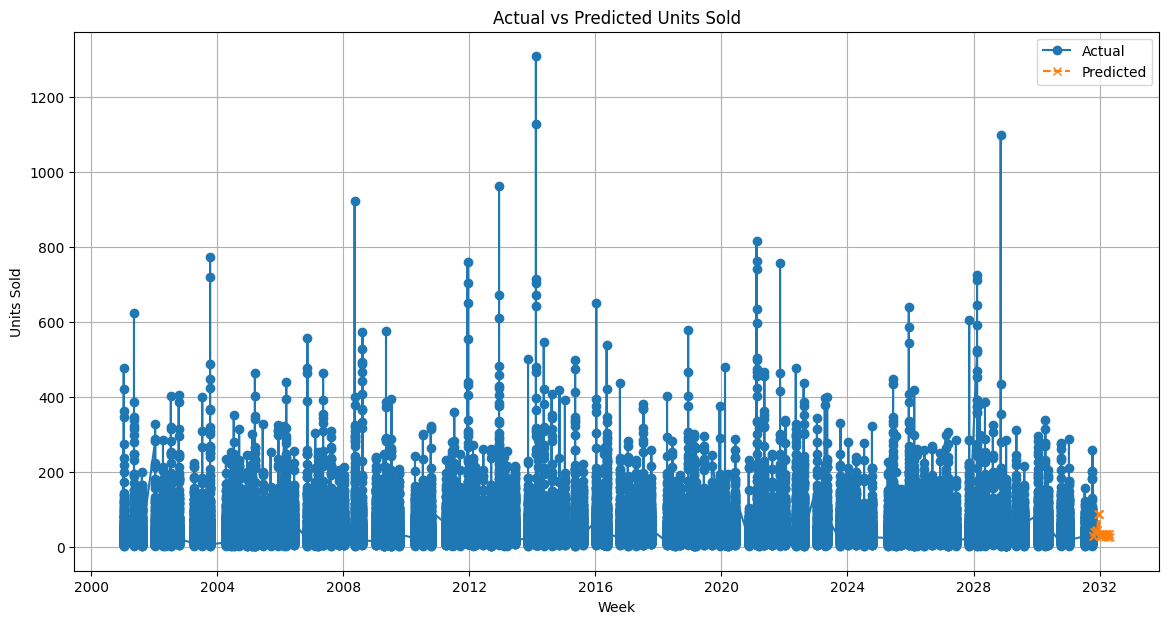

In [24]:
import matplotlib.pyplot as plt

# Ensure future_data includes all necessary columns
future_data['units_sold'] = future_predictions
future_data['type'] = 'Predicted'
future_data['week'] = future_weeks

# Combine actual and predicted data for visualization
combined_data = pd.concat([X_test_with_week[['week', 'units_sold', 'type']], future_data[['week', 'units_sold', 'type']]])

# Sort the data for better plotting
combined_data = combined_data.sort_values(by='week')

# Plot the results
plt.figure(figsize=(14, 7))

# Plot actual data
actual_data = combined_data[combined_data['type'] == 'Actual']
plt.plot(actual_data['week'], actual_data['units_sold'], marker='o', linestyle='-', label='Actual')

# Plot predicted data with a rolling mean to smooth out the line
predicted_data = combined_data[combined_data['type'] == 'Predicted']
plt.plot(predicted_data['week'], predicted_data['units_sold'], marker='x', linestyle='--', label='Predicted')

plt.xlabel('Week')
plt.ylabel('Units Sold')
plt.title('Actual vs Predicted Units Sold')
plt.legend()
plt.grid(True)
plt.show()


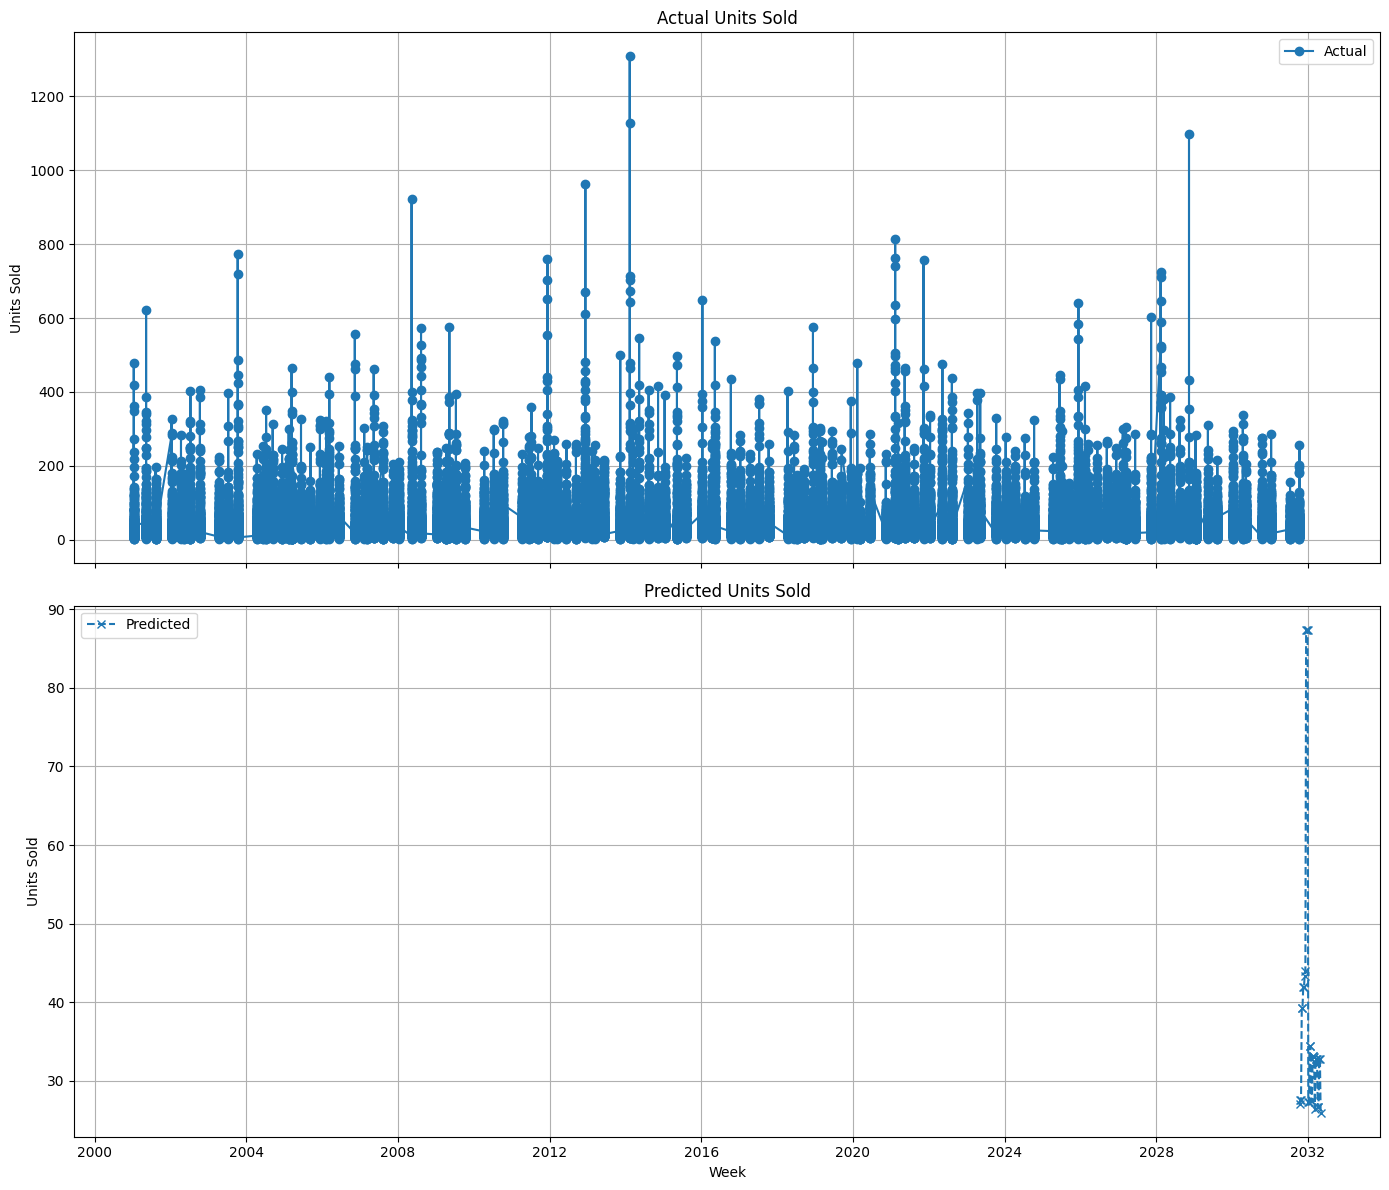

In [25]:
import matplotlib.pyplot as plt

# Ensure future_data includes all necessary columns
future_data['units_sold'] = future_predictions
future_data['type'] = 'Predicted'
future_data['week'] = future_weeks

# Combine actual and predicted data for visualization
combined_data = pd.concat([X_test_with_week[['week', 'units_sold', 'type']], future_data[['week', 'units_sold', 'type']]])

# Sort the data for better plotting
combined_data = combined_data.sort_values(by='week')

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# Plot actual data
actual_data = combined_data[combined_data['type'] == 'Actual']
axes[0].plot(actual_data['week'], actual_data['units_sold'], marker='o', linestyle='-', label='Actual')
axes[0].set_title('Actual Units Sold')
axes[0].set_ylabel('Units Sold')
axes[0].legend()
axes[0].grid(True)

# Plot predicted data
predicted_data = combined_data[combined_data['type'] == 'Predicted']
axes[1].plot(predicted_data['week'], predicted_data['units_sold'], marker='x', linestyle='--', label='Predicted')
axes[1].set_title('Predicted Units Sold')
axes[1].set_xlabel('Week')
axes[1].set_ylabel('Units Sold')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()
